# Module - 1 Data Preparation

 This notebook is made to prepare the data required for determining ETb and Awp. The steps for data preparation are as follows:
* Corrects the ETa layer
* Resamples Precipitation layers with ETa
* Calculates PE (effective rainfall)
* Calculates ET blue
* Clip the land cover map to the study area extend and
* Extracts the irrigated land from Land cover map
* Resample ETb with irrigated cropland raster layer
* Mask ETb with irrigated cropland

# 1. Import the required Libraries and Modules

Mount to the google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Install the required libraries

In [ ]:
!pip install rasterio
!pip install geopandas
!pip install rioxarray
!pip install pyshp
!pip install gdal

Import the modules

In [3]:
import os
import sys
import gc
from pathlib import Path
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
import geopandas as gpd
import pandas as pd
import numpy as np
import rioxarray as riox
import xarray
import dask
from rasterio.features import shapes
import multiprocessing
from tqdm import tqdm
from osgeo import ogr, gdal
import shapefile
import threading
from dask.distributed import Client, progress, LocalCluster, Lock
from dask.utils import SerializableLock
import warnings
import dask.array as da
import rasterio as rio
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr

# 2. Data preparation

* Specify the input and output directory path      **don't forget to add a (/) at the end of the path

In [12]:
input_directory = "/content/drive/MyDrive/Country_based_Colab_WaPOR4Awp/Data/"
output_directory = "/content/drive/MyDrive/Country_based_Colab_WaPOR4Awp/Data/"

## 1. Correcting Actual evapotranspiration & interception layers


In [15]:
def compute_aeti():

    input_aeti_dir = input_directory + "WAPOR.v2_monthly_L1_AETI_M"  ### Paste the folder path for dowloaded AETI data

    input_dir_name = os.path.basename(input_aeti_dir)

    output_aeti_dir = os.path.join(os.path.dirname(output_directory), input_dir_name + "_COR")

    if not os.path.exists(output_aeti_dir):
        os.makedirs(output_aeti_dir)

    for filename in tqdm(os.listdir(input_aeti_dir)):
        if filename.endswith(".tif"):
            input_aeti_file = os.path.join(input_aeti_dir, filename)
            output_file = os.path.join(output_aeti_dir, filename.replace(".tif", "_CORR.tif"))
            with riox.open_rasterio(input_aeti_file) as src:
                corrected = (src * 1).astype("int16")                           ## replace the 0.1 with correction factor of your data
                corrected = corrected.fillna(-9999)                               ## fills the non values with -9999
                corrected = corrected.where((corrected >= 0) & (~corrected.isnull()), other=0)      ## replaces the - values to 0
                corrected.rio.to_raster(output_file, compress="LZW")

In [16]:
compute_aeti()

100%|██████████| 73/73 [00:05<00:00, 13.73it/s]


##2. Resampling Precipitation layers with AETI layers

In [19]:
import os
import rioxarray as riox
from tqdm import tqdm
from rasterio.enums import Resampling

def compute_pcp():
    input_pcp_dir = input_directory + "WAPOR.v2_monthly_L1_PCP_M"                  ### Input data path of dowloaded PCP data
    output_pcp_dir = output_directory + "WAPOR.v2_monthly_L1_PCP_M_CORR"           ### output folder path

    if not os.path.exists(output_pcp_dir):
        os.makedirs(output_pcp_dir)

    resampler = riox.open_rasterio("/content/drive/MyDrive/Country_based_Colab_WaPOR4Awp/Data/WAPOR.v2_monthly_L1_AETI_M_COR/L1_AETI_1501M_CORR.tif")     ## Paste the path of a file from corrected AETI folder

    for filename in tqdm(os.listdir(input_pcp_dir)):
        if filename.endswith(".tif"):
            input_pcp_file = os.path.join(input_pcp_dir, filename)
            output_file = os.path.join(output_pcp_dir, filename.replace(".tif", "_CORR.tif"))
            with riox.open_rasterio(input_pcp_file) as src:
                resampled = src.rio.reproject_match(resampler, resampling=Resampling.bilinear)
                resampled = (resampled).astype("int16")
                resampled = resampled.fillna(-9999)
                resampled.rio.to_raster(output_file, compress="LZW")

In [20]:
compute_pcp()

100%|██████████| 72/72 [00:27<00:00,  2.66it/s]


## 3. Calculating Effective rainfall (PE)

Amount of rainfall that actually contributes to plant growth and soil moisture recharge. It is the portion of precipitation that is not lost due to evaporation, runoff or deep percolation.

PE is calculated using the below formula:

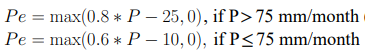


Reference: Brouwer, C., & Heibloem, M. (1986). Irrigation water management: irrigation water needs. Training manual, 3, 1-5.

In [21]:
import os
import numpy as np
import rasterio
from tqdm.notebook import tqdm

def compute_pe():
    input_pcp_dir = output_directory + "WAPOR.v2_monthly_L1_PCP_M_CORR"          ### path of resampled PCP directory
    output_pe_dir = output_directory + "PE"                                      ### path of output directory

    if not os.path.exists(output_pe_dir):
        os.makedirs(output_pe_dir)

    for filename in tqdm(os.listdir(input_pcp_dir)):
        if filename.endswith(".tif") and filename.startswith("L1_PCP_"):
            input_file = os.path.join(input_pcp_dir, filename)
            output_file = os.path.join(output_pe_dir, filename.replace("L1_PCP_", "L1_PE_"))

            if os.path.exists(output_file):
                continue

            with rasterio.open(input_file) as src:
                data = src.read(1)
                pe = np.where(data > 75, (data * 0.8) - 25, 0)
                pe = np.where(pe >= 0, pe, 0)
                pe = np.where(data <= 75, np.fmax((data * 0.6) - 10, 0), pe)
                pe = np.where(np.isnan(pe), -9999, pe)

                # Save the result
                with rasterio.open(output_file, 'w', **src.meta) as dst:
                    dst.write(pe, 1)

In [22]:
compute_pe()

  0%|          | 0/72 [00:00<?, ?it/s]

##4. Calculating ETb

After computing PE (Green ET) the Blue ET is calculated by subtracting PE from Actual evapotranspiration using the below formula:

  * Actual ET = Blue ET + Green ET

In [23]:
def compute_etb_m():

    input_aeti_dir = output_directory + "WAPOR.v2_monthly_L1_AETI_M_COR"    ### path of corrected AETI directory
    input_pe_dir = output_directory + "PE"                                  ### path of PE directory
    output_dir = output_directory + "ETb"                                   ### path of output directory to save ETb

    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)

    chunk_size = "auto"

    for aeti_file in tqdm(os.listdir(input_aeti_dir)):
        if aeti_file.startswith("L1_AETI_") and aeti_file.endswith(".tif"):
            pe_file = "L1_PE_" + "_".join(aeti_file.split("_")[2:])

            if pe_file in os.listdir(input_pe_dir):
                aeti_path = os.path.join(input_aeti_dir, aeti_file)
                pe_path = os.path.join(input_pe_dir, pe_file)
                with rio.open(aeti_path) as aeti_src, rio.open(pe_path) as pe_src:
                    aeti = da.from_array(aeti_src.read(1), chunks=chunk_size).astype(pe_src.profile['dtype'])
                    pe = da.from_array(pe_src.read(1), chunks=chunk_size).astype(aeti_src.profile['dtype'])

                    etb = da.where(aeti - pe >= 0, aeti - pe, 0)
                    etb = np.nan_to_num(etb)
                    output_file = "L1_Etb_" + "_".join(pe_file.split("_")[2:])
                    output_path = os.path.join(output_dir, output_file)
                    with rio.open(output_path, 'w', **aeti_src.profile) as dst:
                        dst.write(etb.astype(aeti_src.profile['dtype']), 1)

In [24]:
compute_etb_m()

  0%|          | 0/72 [00:00<?, ?it/s]

##5. Clipping Land cover raster data with study area shapefile

In [ ]:
from rasterio.mask import mask
import os

input_folder = input_directory + 'WAPOR.v2_yearly_L1_LCC_A'                                                              ### path of downloaded Land cover map directory

output_folder = output_directory + "WAPOR.v2_yearly_L1_LCC_A_clipped"                                                    ### creates output folder for clipped layers
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

study_area_shapefile = '/content/drive/MyDrive/Country_based_Colab_WaPOR4Awp/Data/1Boundary/Shapefile/LEBMASKD.shp'     ### path to the study area shapefile
study_area_gdf = gpd.read_file(study_area_shapefile)

study_area_geometry = study_area_gdf.geometry.__geo_interface__

for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        input_tif_file = os.path.join(input_folder, filename)
        output_tif_file = os.path.join(output_folder, filename.replace(".tif", "_clipped.tif"))

        with rasterio.open(input_tif_file) as src:
            clipped_data, clipped_transform = mask(src, [study_area_geometry['features'][0]['geometry']], crop=True)

            meta = src.meta
            meta.update(transform=clipped_transform, width=clipped_data.shape[2], height=clipped_data.shape[1])

            with rasterio.open(output_tif_file, 'w', **meta) as dst:
                dst.write(clipped_data)

        print(f"Clipping completed for {filename}. Output TIFF file saved as {output_tif_file}.")

print("Clipping process completed for all files.")



#6. Extracting Irrigated land from Land cover map



In WaPOR LCC layer, pixel value **42** represents irrigated cropland (See https://wapor.apps.fao.org/catalog/2/L2_LCC_A).

![title](https://github.com/wateraccounting/WAPORWP/blob/master/Notebooks/img/Fig1_2.png?raw=true)

In [ ]:
import rasterio
import numpy as np
import csv
import os

input_folder = output_directory + 'WAPOR.v2_yearly_L1_LCC_A_clipped'                          ### path to the clipped Land cover map to study area
output_folder = os.path.join(output_directory , os.path.basename(input_folder) + "_42")       ### saves the output files in a new directory with same name as input file with _42
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

output_tif_file = os.path.join(output_folder, os.path.basename(input_folder) + "_42.tif")

class_to_extract = 42

for filename in os.listdir(input_folder):
    if filename.endswith(".tif"):
        input_tif_file = os.path.join(input_folder, filename)

        with rasterio.open(input_tif_file) as src:
            raster_data = src.read(1)

            class_pixels = np.where(raster_data == class_to_extract, class_to_extract, 0)

            no_data_value = src.nodatavals[0]

            class_pixels[class_pixels == 0] = no_data_value

            meta = src.meta

            meta.update(count=1, compress='lzw', nodata=no_data_value)

            output_tif_file = os.path.join(output_folder, filename.replace(".tif", "_42.tif"))
            with rasterio.open(output_tif_file, 'w', **meta) as dst:
                dst.write(class_pixels, 1)

            attribute_table = src.read(1)
            extracted_values = attribute_table[class_pixels == class_to_extract]

        print(f"Extraction completed for {filename}. Output TIFF file saved as {output_tif_file}")

print("Extraction process completed for all files.")


#7. Resampling ETb with irrigated cropland raster layer

In [29]:
import os
import glob
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
import numpy as np

etb_folder = output_directory + "ETb"                                                                      # Path to the folder containing the ETb files
irrigated_land_file = output_directory + "WAPOR.v2_yearly_L1_LCC_A_clipped_42/L1_LCC_15_clipped_42.tif"    # Path to the irrigated land raster file
output_folder = output_directory + "Resampled_ETb"                                                         # Path to the output folder to save resampled ETb files

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

etb_files = glob.glob(os.path.join(etb_folder, "*.tif"))

with rasterio.open(irrigated_land_file) as irrigated_land_src:
    irrigated_land_data = irrigated_land_src.read(1)
    profile = irrigated_land_src.profile
    transform = profile["transform"]
    crs = profile["crs"]
    height = profile["height"]
    width = profile["width"]

    for etb_file in etb_files:
        with rasterio.open(etb_file) as etb_src:
            etb_data = etb_src.read(1)
            etb_transform = etb_src.profile["transform"]
            etb_crs = etb_src.profile["crs"]
            etb_height = etb_src.profile["height"]
            etb_width = etb_src.profile["width"]

            etb_data_resampled = np.empty((height, width), dtype=etb_data.dtype)
            reproject(
                etb_data,
                etb_data_resampled,
                src_transform=etb_transform,
                src_crs=etb_crs,
                dst_transform=transform,
                dst_crs=crs,
                resampling=Resampling.nearest,
            )

            _, etb_filename = os.path.split(etb_file)

            output_file = os.path.join(output_folder, etb_filename.replace(".tif", "_resampled.tif"))

            with rasterio.open(output_file, "w", **profile) as output:
                output.write(etb_data_resampled, 1)


#8. Masking ETb with irrigated cropland

In [ ]:
import os
import numpy as np
import rasterio

etb_folder = output_directory + 'Resampled_ETb'                                         # Define the Resampled ETb folder path

irrigation_folder = output_directory + 'WAPOR.v2_yearly_L1_LCC_A_clipped_42'            # Define the path to the irrigation rasters location

output_folder = output_directory + 'ETb_42'                                             # Path to the output folder to save masked ETb files
os.makedirs(output_folder, exist_ok=True)

etb_files = [f for f in os.listdir(etb_folder) if f.endswith('.tif')]

for etb_filename in etb_files:
    etb_xx = etb_filename.split('_')[2][:2]

    irrigation_files = [f for f in os.listdir(irrigation_folder) if etb_xx in f and f.endswith('.tif')]

    if len(irrigation_files) > 0:
        etb_path = os.path.join(etb_folder, etb_filename)
        with rasterio.open(etb_path) as etb_dataset:
            etb_data = etb_dataset.read(1)

            for irrigation_filename in irrigation_files:
                irrigation_path = os.path.join(irrigation_folder, irrigation_filename)
                with rasterio.open(irrigation_path) as irrigation_dataset:
                    irrigation_data = irrigation_dataset.read(1)

                    modified_irrigation_data = np.where(irrigation_data == 42, 1, 0)

                    result_data = modified_irrigation_data * etb_data

                    result_data[result_data == 0] = etb_dataset.nodata

                    result_profile = etb_dataset.profile
                    result_profile.update(count=1)

                    # Write the result data to the output raster
                    output_filename = etb_filename.replace('.tif', '_result.tif')
                    output_path = os.path.join(output_folder, output_filename)
                    with rasterio.open(output_path, 'w', **result_profile) as result:
                        result.write(result_data, 1)

                    print('Result saved to:', output_path)
    else:
        print('No corresponding irrigation file found for:', etb_filename)


#9. Resampling Gross Biomass layers with Irrigated land layer

In [37]:
import os
import glob
import rasterio
from rasterio.enums import Resampling
from rasterio.warp import reproject, Resampling
import numpy as np

gbwp_folder = input_directory + "WAPOR.v2_yearly_L1_GBWP_A"                                                  # Path to the folder containing the GBWP files
irrigated_land_file = output_directory + "WAPOR.v2_yearly_L1_LCC_A_clipped_42/L1_LCC_15_clipped_42.tif"     # Path to the irrigated land raster file
output_folder = output_directory + "Resampled_GBWP"                                                          # Path to the output folder to save resampled GBWP files

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

gbwp_files = glob.glob(os.path.join(gbwp_folder, "*.tif"))

with rasterio.open(irrigated_land_file) as irrigated_land_src:
    irrigated_land_data = irrigated_land_src.read(1)
    profile = irrigated_land_src.profile
    transform = profile["transform"]
    crs = profile["crs"]
    height = profile["height"]
    width = profile["width"]
    nodata_value = -9999

    for gbwp_file in gbwp_files:
        with rasterio.open(gbwp_file) as gbwp_src:
            gbwp_data = gbwp_src.read(1)
            gbwp_transform = gbwp_src.profile["transform"]
            gbwp_crs = gbwp_src.profile["crs"]
            gbwp_height = gbwp_src.profile["height"]
            gbwp_width = gbwp_src.profile["width"]

            gbwp_data_resampled = np.empty((height, width), dtype=gbwp_data.dtype)
            reproject(
                gbwp_data,
                gbwp_data_resampled,
                src_transform=gbwp_transform,
                src_crs=gbwp_crs,
                dst_transform=transform,
                dst_crs=crs,
                resampling=Resampling.nearest,
            )

            gbwp_data_resampled[gbwp_data_resampled == nodata_value] = profile["nodata"]  # Set nodata value in resampled data

            _, gbwp_filename = os.path.split(gbwp_file)

            output_file = os.path.join(output_folder, gbwp_filename.replace(".tif", "_resampled.tif"))

            with rasterio.open(output_file, "w", **profile) as output:
                output.write(gbwp_data_resampled, 1)


#10. Masking Gross Biomass Layer with Irrigated land raster layer

In [ ]:
import os
import numpy as np
import rasterio

GBWP_folder = output_directory + 'Resampled_GBWP'                              # Define the  resampled GBWP folder path

irrigation_folder = output_directory + 'WAPOR.v2_yearly_L1_LCC_A_clipped_42'            # Define the path to the irrigation rasters location

output_folder = output_directory + 'GBWP_42'                                        # Path to the output folder to save masked GBWP files
os.makedirs(output_folder, exist_ok=True)

GBWP_files = [f for f in os.listdir(GBWP_folder) if f.endswith('.tif')]

for GBWP_filename in GBWP_files:
    GBWP_xx = GBWP_filename.split('_')[2][:2]

    irrigation_files = [f for f in os.listdir(irrigation_folder) if GBWP_xx in f and f.endswith('.tif')]

    if len(irrigation_files) > 0:
        GBWP_path = os.path.join(GBWP_folder, GBWP_filename)
        with rasterio.open(GBWP_path) as GBWP_dataset:
            GBWP_data = GBWP_dataset.read(1)

            for irrigation_filename in irrigation_files:
                irrigation_path = os.path.join(irrigation_folder, irrigation_filename)
                with rasterio.open(irrigation_path) as irrigation_dataset:
                    irrigation_data = irrigation_dataset.read(1)

                    modified_irrigation_data = np.where(irrigation_data == 42, 1, 0)

                    result_data = modified_irrigation_data * GBWP_data

                    result_data[result_data == 0] = GBWP_dataset.nodata

                    result_profile = GBWP_dataset.profile
                    result_profile.update(count=1)

                    # Write the result data to the output raster
                    output_filename = GBWP_filename.replace('.tif', '_result.tif')
                    output_path = os.path.join(output_folder, output_filename)
                    with rasterio.open(output_path, 'w', **result_profile) as result:
                        result.write(result_data, 1)

                    print('Result saved to:', output_path)
    else:
        print('No corresponding irrigation file found for:', GBWP_filename)


Continue with the next module . .